In [136]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import os, json
from tqdm import tqdm
import torch as ch
from torchvision import models, transforms
from torch.autograd import Variable

from lime import lime_image
from skimage.segmentation import mark_boundaries

In [137]:
import utils
import implem_utils

In [138]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

def get_input_tensors(img):
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)

In [139]:
def get_model(path):
    model = utils.FaceModel(512,
                            train_feat=True,
                            weight_init=None,
                            hidden=[64, 16]).cuda()
    model = nn.DataParallel(model)
    model.load_state_dict(ch.load(path), strict=False)
    model.eval()
    return model

In [140]:
# constants = utils.Celeb()
# ds = constants.get_dataset()

# attrs = constants.attr_names

In [141]:
def raw_255_image(z):
    z_ = z.numpy().transpose(1, 2, 0)
    z_ = (z_ + 1) / 2
    return (z_ * 255).astype(np.uint8)

In [142]:
def show_image(z):
    plt.imshow(raw_255_image(z))

In [143]:
def batch_predict(model, images):
    batch = ch.stack(tuple(transform(i) for i in images), dim=0)
    
    logits = model(batch.cuda()).detach()
    probs = ch.sigmoid(logits)
    probs = ch.stack([1 - probs[:, 0], probs[:, 0]], 1)
    return probs.cpu().numpy()

In [178]:
def get_scores(model):
    constants = utils.Celeb()
    ds = constants.get_dataset()
    td = utils.CelebACustomBinary(
        "/p/adversarialml/as9rw/datasets/celeba_raw_crop/splits/70_30/all/split_2/test",
        transform=transform)
    cropped_dataloader = DataLoader(td,
                                batch_size=15,
                                shuffle=False)
    
    explainer = lime_image.LimeImageExplainer()
    
    def model_batch_predict(x):
        return batch_predict(model, x)

    scores = []
    labels = []

    for i, (x, y) in tqdm(enumerate(cropped_dataloader)):
        x_raw = [raw_255_image(x_) for x_ in x]
        labels.append(y.numpy())
        
        if i < 1:
            continue
    
        for img_t in x_raw:
            explanation = explainer.explain_instance(img_t,
                                                     model_batch_predict, # classification function
                                                     top_labels=1, 
                                                     hide_color=0, 
                                                     num_samples=2000)
    
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=True,
                                                        num_features=5,
                                                        hide_rest=False)
    
            img_boundry1 = mark_boundaries(temp/255.0, mask)
            plt.imshow(img_boundry1)
            return
            
            temp_pos = temp * (np.expand_dims(mask, 2))
            temp_neg = temp * (1 - np.expand_dims(mask, 2))
            test_pred = model_batch_predict([temp_pos.astype(np.uint8), temp_neg.astype(np.uint8)])
            scores.append(test_pred[:, 1])
        
        if i == 3: break
    
    return np.stack(scores, 0), np.concatenate(labels, 0)

0it [00:00, ?it/s]

1it [00:27, 27.13s/it]

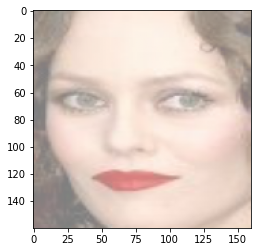

In [179]:
model = get_model("/u/as9rw/work/fnb/implems/celeba_models_split/70_30/split_1/all/augment_vggface/10_0.928498243559719.pth")
get_scores(model)

0it [00:00, ?it/s]

1it [00:24, 24.88s/it]

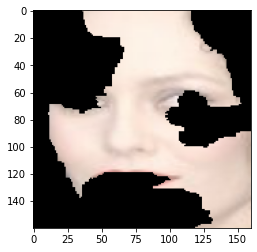

In [175]:
model = get_model("/u/as9rw/work/fnb/implems/celeba_models_split/70_30/split_1/all/augment_vggface/20_0.9151053864168618.pth")
get_scores(model)

0it [00:00, ?it/s]

1it [00:27, 27.74s/it]

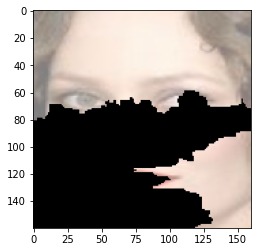

In [176]:
model = get_model("/u/as9rw/work/fnb/implems/celeba_models_split/70_30/split_1/all/augment_vggface/4_0.9207406323185011.pth")
get_scores(model)

0it [00:00, ?it/s]

1it [00:23, 23.01s/it]

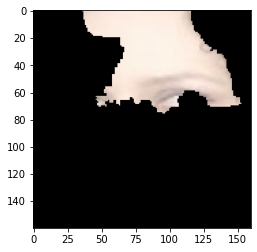

In [177]:
model = get_model("/u/as9rw/work/fnb/implems/celeba_models_split/70_30/split_1/male/augment_vggface/20_0.9246347941567065.pth")
get_scores(model)

In [104]:
labels.shape

(20, 40)

In [107]:
where_male = np.nonzero(labels[:, attrs.index("Male")])[0]

In [108]:
where_female = np.nonzero(1 - labels[:, attrs.index("Male")])[0]

In [113]:
np.mean(scores[where_male, 0] - scores[where_male, 1])

-0.15906781

In [114]:
np.mean(scores[where_female, 0] - scores[where_female, 1])

-0.19929704